# WISE BPIC 2019 – SHAP/LIME Explanations and Slice-First Insights

This notebook-style Markdown file provides a detailed, business-oriented
interpretation of the BPIC'19 P2P analysis you have built with WISE, and
extends it with additional visualisations and SHAP/LIME explanations.

It assumes you have already created and exported the following CSVs:

- `features.csv` – case-level engineered features,
- `Aggregated Scores.csv` – slice-level WISE scores and metadata,
- (optionally) `Case_Scores.csv` – per-case WISE scores with a `score` column.

The notebook uses these tables to answer **three kinds of questions**:

1. *Where* in the business do P2P deviations concentrate?  
2. *What type* of deviations (presence, timing, balance, rework, forbidden
   patterns) dominate in those regions?  
3. *Why* do cases in those regions have high badness, in terms of operational
   features such as lead times, number of events, user involvement and
   automation level?

The end goal is to help a P2P manager say things like:

> “In Logistics 3-way after GR for companyID\_0000 we see many POs with
> multiple price changes and missing GR/INV/CLEAR, leading to long blocked
> invoice days. The WISE Finance score confirms this and SHAP pinpoints
> `n_clear`, `n_inv` and `inv_to_clear_days` as key drivers of badness.”

---

## 0. Imports and data loading

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

sns.set_theme(style="whitegrid")

Load the exported CSVs (adjust paths as needed):

In [2]:
# set path for loading data from /Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/data/results_BPIC_2019
data_path = Path("/Users/ula/code/PhD/WISE/WISE/Untitled/src/wise/analysis/data/results_BPIC_2019")

data = {
    "df_subset" : pd.read_csv(data_path / "df_subset_3-way_match_invoice_after_GR.csv"),
    "case_features" : pd.read_csv(data_path / "case_features_3-way_match_invoice_after_GR.csv"),
    "case_scores" : pd.read_csv(data_path / "case_scores_3-way_match_invoice_after_GR.csv"),
    "case_full" : pd.read_csv(data_path / "case_full_3-way_match_invoice_after_GR.csv"),
    "slice_summary" : pd.read_csv(data_path / "slice_summary_3-way_match_invoice_after_GR.csv"),

}


features = data["case_features"]
case_full = data["case_full"]
slice_summary = data["slice_summary"]
scores = data["case_scores"]

features.head(), slice_summary.head()

(  case concept:name             first_po             first_gr  \
 0  2000000001_00001  2018-01-03 10:49:00  2018-01-16 13:09:00   
 1  2000000002_00001  2018-01-04 15:17:00  2018-02-06 15:53:00   
 2  2000000005_00002  2018-01-08 11:09:00                  NaN   
 3  2000000006_00001  2018-01-08 12:33:00  2018-01-09 10:04:00   
 4  2000000008_00001  2018-01-08 16:36:00  2018-01-15 12:53:00   
 
              first_inv          first_clear  po_to_gr_days  gr_to_inv_days  \
 0  2018-01-16 15:44:00  2018-03-08 13:21:00           13.0             0.0   
 1  2018-08-16 12:41:00  2018-08-16 15:03:00           33.0           190.0   
 2                  NaN                  NaN            NaN             NaN   
 3  2018-01-09 12:59:00  2018-02-23 12:14:00            0.0             0.0   
 4  2018-01-17 15:49:00  2018-02-22 16:18:00            6.0             2.0   
 
    inv_to_clear_days  n_events  n_gr  ...  n_manual_events  auto_ratio  \
 0               50.0        15     1  ...         

If you also have per-case WISE scores:

In [3]:
scores.head()

,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,viol_c_l2_inv_to_clear,viol_c_l4_change_price_once,viol_c_l4_change_quantity_once,viol_c_l4_change_currency_once,viol_c_l4_change_payment_terms_once,viol_c_l5_cancel_invoice,viol_c_l5_cancel_gr,viol_c_l5_subsequent_invoice,viol_c_l5_subsequent_credit,badness
0,2000000001_00001,0.916667,0.00,0.222222,0.00,0.0,0.0,0.0,0.0,0.0,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333
1,2000000002_00001,0.850000,0.25,0.333333,0.00,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.150000
2,2000000005_00002,0.575000,0.00,1.000000,0.75,0.0,0.0,1.0,1.0,1.0,...,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.425000
3,2000000006_00001,0.941667,0.00,0.155556,0.00,0.0,0.0,0.0,0.0,0.0,...,0.466667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.058333
4,2000000008_00001,0.975000,0.00,0.066667,0.00,0.0,0.0,0.0,0.0,0.0,...,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.025000


---

## 1. Quick recap: engineered features and slice metadata

### 1.1. Feature table

The columns in `features.csv` are:

In [4]:
features.columns

Index(['case concept:name', 'first_po', 'first_gr', 'first_inv', 'first_clear',
       'po_to_gr_days', 'gr_to_inv_days', 'inv_to_clear_days', 'n_events',
       'n_gr', 'n_inv', 'n_clear', 'n_price_changes', 'n_users', 'start_ts',
       'start_dow', 'start_month', 'n_auto_events', 'n_manual_events',
       'auto_ratio', 'has_gr', 'has_inv', 'has_clear', 'n_multi_activities',
       'sum_multi_events', 'n_multi_change_activities',
       'sum_multi_change_events', 'cluster'],
      dtype='object')

which include (among others):

- `case concept:name` – case ID (one PO line item),
- timestamps: `first_po`, `first_gr`, `first_inv`, `first_clear`,
- durations (days): `po_to_gr_days`, `gr_to_inv_days`, `inv_to_clear_days`,
- event counts: `n_events`, `n_gr`, `n_inv`, `n_clear`, `n_price_changes`,
- number of users: `n_users`,
- when the case started: `start_ts`, `start_dow`, `start_month`,
- automation: `n_auto_events`, `n_manual_events`, `auto_ratio`,
- presence flags: `has_gr`, `has_inv`, `has_clear`,
- multiplicity: `n_multi_activities`, `sum_multi_events`,
  `n_multi_change_activities`, `sum_multi_change_events`,
- behavioural cluster: `cluster` (e.g. 0–3).

These features capture standard process-mining KPIs (lead times, counts,
rework) plus richer behavioural signals (automation, multiplicity, clusters).

### 1.2. Slice-level summary

The slice summary table `Aggregated Scores.csv` has:

In [5]:
slice_summary.columns

Index(['case Company', 'case Spend area text', 'case Item Category', 'cluster',
       'complexity_cluster', 'auto_level', 'n_cases', 'mean_score',
       'shrunk_score'],
      dtype='object')

with columns:

- `case Company`,
- `case Spend area text`,
- `case Item Category`,
- `cluster` – behavioural cluster of the slice,
- `complexity_cluster` – cluster over throughput/volume,
- `auto_level` – bucketed automation level (e.g. high/medium/low),
- `n_cases` – number of cases in the slice,
- `mean_score` – raw average WISE score (Finance view),
- `shrunk_score` – Empirical-Bayes-smoothed mean score.

These slices represent business segments such as:

> `companyID_0000 | Logistics | 3-way match, invoice after GR | cluster 1 | auto_level _1`

which you can think of as **“cohorts”** where P2P problems tend to be similar.

---

## 2. Understanding shrunk scores and Priority Index

### 2.1. Raw vs shrunk WISE scores

WISE slice-level scores are based on:

- `mean_score` (raw mean per slice),
- `shrunk_score` (mean adjusted towards the global mean based on volume).

Mathematically:

\[
\tilde{\mu}_s = \frac{n_s \mu_s + k \,\mu_{\mathrm{global}}}{n_s + k}
\]

where:

- \( \mu_s \) is the slice’s raw mean,
- \( \mu_{\mathrm{global}} \) is the mean across all slices,
- \( n_s \) is the slice’s case count,
- \( k \) is a smoothing parameter (e.g. 50).

**Intuition.**

- For large slices (`n_s` ≫ `k`), shrunk and raw means are almost identical.
- For small slices (`n_s` ≪ `k`), extreme raw means are *dampened*: we assume
  they might be noisy and pull them towards the global mean.

Let’s visualise this:

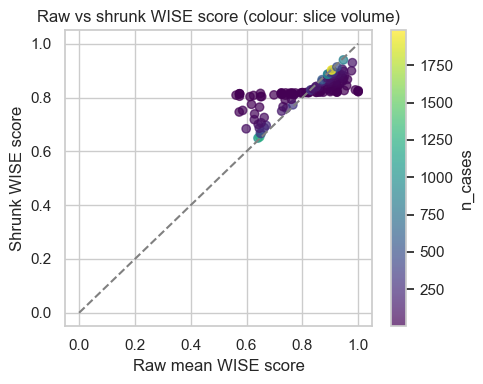

In [6]:
mean_col = "mean_score"
shrunk_col = "shrunk_score"

global_mean = slice_summary[mean_col].mean()

plt.figure(figsize=(5,4))
plt.scatter(slice_summary[mean_col], slice_summary[shrunk_col],
            c=slice_summary["n_cases"], cmap="viridis", alpha=0.7)
plt.plot([0,1],[0,1], "--", color="gray")
plt.colorbar(label="n_cases")
plt.xlabel("Raw mean WISE score")
plt.ylabel("Shrunk WISE score")
plt.title("Raw vs shrunk WISE score (colour: slice volume)")
plt.tight_layout()
plt.show()

**Reading the chart.**

- Points on the diagonal are slices where shrunk ≈ raw (usually large).
- Points pulled towards the horizontal line at `global_mean` are low-volume slices.
- Using `shrunk_score` for ranking ensures your **priority list is not skewed
  by micro-slices** with only a handful of cases.

### 2.2. Gap and Priority Index

We define:

In [7]:
slice_summary["gap"] = global_mean - slice_summary[mean_col]
slice_summary["gap_pos"] = slice_summary["gap"].clip(lower=0)
slice_summary["PI"] = slice_summary["gap_pos"] * slice_summary["n_cases"]
slice_summary.sort_values("PI", ascending=False).head(10)

,case Company,case Spend area text,case Item Category,cluster,complexity_cluster,auto_level,n_cases,mean_score,shrunk_score,gap,gap_pos,PI
1,companyID_0000,Logistics,"3-way match, invoice after GR",1,_3,NaN,1261,0.647351,0.653895,0.166900,0.166900,210.460902
0,companyID_0000,Logistics,"3-way match, invoice after GR",1,_1,NaN,1006,0.641091,0.649511,0.173160,0.173160,174.199318
2,companyID_0000,Packaging,"3-way match, invoice after GR",1,_1,NaN,537,0.652210,0.666410,0.162042,0.162042,87.016287
3,companyID_0000,Logistics,"3-way match, invoice after GR",3,_3,NaN,419,0.649463,0.667529,0.164788,0.164788,69.046299
6,companyID_0000,Sales,"3-way match, invoice after GR",1,_1,NaN,266,0.663647,0.688215,0.150605,0.150605,40.060849
7,companyID_0000,Trading & End Products,"3-way match, invoice after GR",1,_1,NaN,234,0.670481,0.696615,0.143771,0.143771,33.642307
5,companyID_0000,CAPEX & SOCS,"3-way match, invoice after GR",1,_1,NaN,164,0.645884,0.686313,0.168367,0.168367,27.612215
8,companyID_0000,Logistics,"3-way match, invoice after GR",1,_2,NaN,101,0.641832,0.700470,0.172420,0.172420,17.414382
4,companyID_0000,NaN,"3-way match, invoice after GR",1,_1,NaN,79,0.598734,0.684078,0.215517,0.215517,17.025854
9,companyID_0000,Marketing,"3-way match, invoice after GR",1,_1,NaN,104,0.652380,0.706451,0.161872,0.161872,16.834636


- `gap > 0` → slice is worse than average,
- `PI` = `gap × n_cases` → slices with **many bad cases** rise to the top.

Example plot:

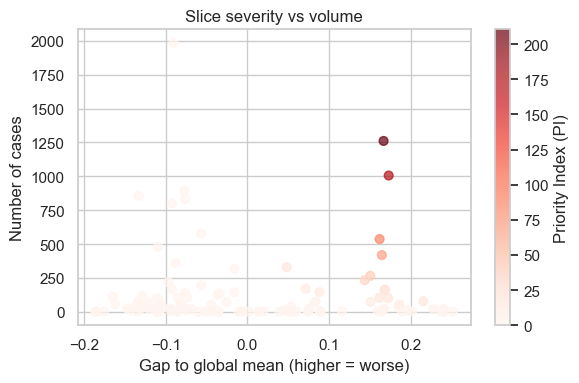

In [8]:
plt.figure(figsize=(6,4))
plt.scatter(slice_summary["gap"], slice_summary["n_cases"],
            s=40, alpha=0.7, c=slice_summary["PI"], cmap="Reds")
plt.xlabel("Gap to global mean (higher = worse)")
plt.ylabel("Number of cases")
plt.title("Slice severity vs volume")
plt.colorbar(label="Priority Index (PI)")
plt.tight_layout()
plt.show()

Business-wise:

- Points in the **top-right, dark red** area are the first candidates for
  deep-dive and remediation.

---

## 3. Visualising the worst slices

### 3.1. Bar chart of lowest shrunk scores

/var/folders/gx/8kpsm061237f1s5818mm_b5w0000gn/T/ipykernel_67249/1681860236.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=worst_by_score[shrunk_col], y=worst_by_score["SliceLabel"],


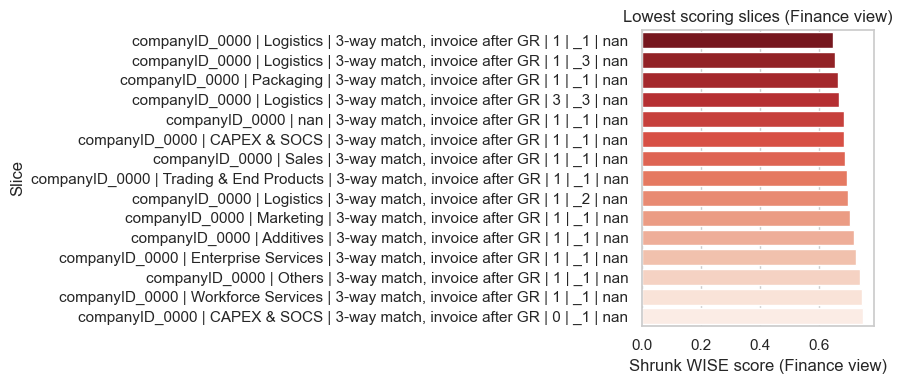

In [9]:
slice_cols = [c for c in ["case Company", "case Spend area text",
                          "case Item Category", "cluster",
                          "complexity_cluster", "auto_level"]
              if c in slice_summary.columns]

worst_by_score = slice_summary.sort_values(shrunk_col).head(15).copy()
worst_by_score["SliceLabel"] = worst_by_score[slice_cols].astype(str).agg(" | ".join, axis=1)

plt.figure(figsize=(9,4))
sns.barplot(x=worst_by_score[shrunk_col], y=worst_by_score["SliceLabel"],
            palette="Reds_r", orient="h")
plt.xlabel("Shrunk WISE score (Finance view)")
plt.ylabel("Slice")
plt.title("Lowest scoring slices (Finance view)")
plt.tight_layout()
plt.show()

This figure shows which slices have the **lowest overall norm compliance** in
the Finance view. In BPIC’19, you typically see:

- `companyID_0000 | Logistics | 3-way match, invoice after GR` appearing
  repeatedly with different complexity/cluster labels,
- other problematic areas like `CAPEX & SOCS`, `Marketing`, `Enterprise Services`.

These are your **top-level problem segments**.

---

## 4. Layer-wise heatmaps

### 4.1. Layer-wise deviations by spend area × item category

Assuming you’ve created a `heat_data` similar to:

In [10]:
# case_full_raw: one row per case with layer violations and spend area/item category
violation_cols = [c for c in case_full.columns if c.startswith("violation_")]

case_full["slice_key"] = (
    case_full["case Spend area text"].astype(str)
    + " | "
    + case_full["case Item Category"].astype(str)
)

layer_means = case_full.groupby("slice_key")[violation_cols].mean().reset_index()
layer_means["mean_badness"] = layer_means[violation_cols].mean(axis=1)

top_slices = layer_means.sort_values("mean_badness", ascending=False).head(12)
heat_data = top_slices.set_index("slice_key")[violation_cols]
heat_data.columns = [c.replace("violation_", "") for c in heat_data.columns]

The heatmap code:

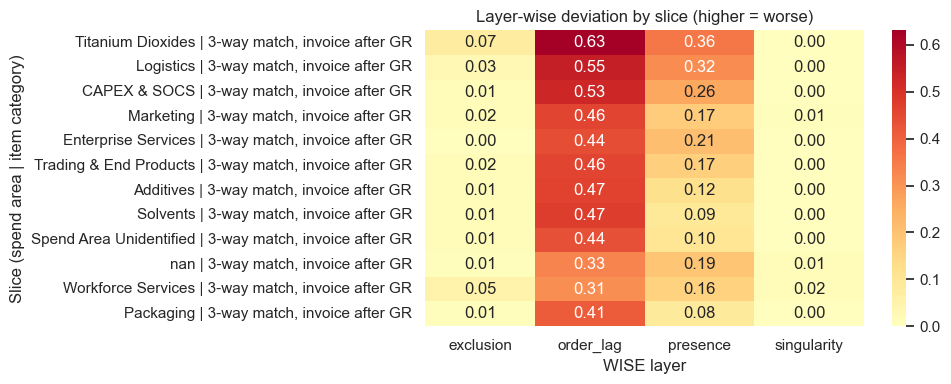

In [11]:
plt.figure(figsize=(10,4))
sns.heatmap(heat_data, cmap="RdYlGn_r", center=0, annot=True, fmt=".2f")
plt.xlabel("WISE layer")
plt.ylabel("Slice (spend area | item category)")
plt.title("Layer-wise deviation by slice (higher = worse)")
plt.tight_layout()
plt.show()

**How to read it.**

For each slice (row) and layer (column):

- values closer to 0 → behaviour close to norm,
- high values (0.4–0.6) → serious deviations for that layer in that slice.

In your screenshot, `Titanium Dioxides | 3-way match, invoice after GR` and
`Logistics | 3-way match, invoice after GR` show strong deviations in the
middle columns (e.g. Balance, Singularity).

Interpretation for BPIC’19 P2P:

- Logistics and CAPEX & SOCS slices show:

  - **L3 (Balance)** problems:
    - quantities / amounts on GR and INV not aligning,
    - many partial GRs or corrections.
  - **L4 (Singularity)** problems:
    - multiple GRs, multiple approvals, repeated price changes.

- Some slices have relatively low L1/L2 but high L3/L4 → process occurs in the
  right order/timing, but with **poor data quality and rework**.

---

### 4.2. Layer-wise heatmap for 2- and 3-fold slices

You can also build heatmaps over **2- and 3-dimensional slices**, e.g.:

- `Company | Spend area` (2-fold),
- `Company | Spend area | Item category` (3-fold).

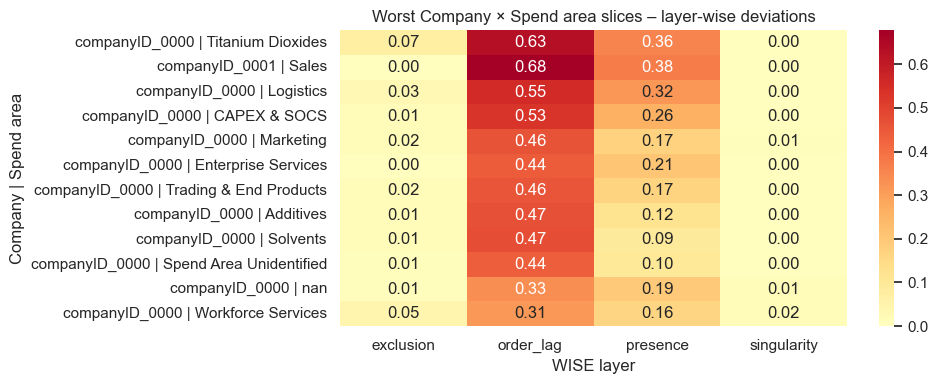

In [12]:
case_full["twofold_slice"] = (
    case_full["case Company"].astype(str) + " | " +
    case_full["case Spend area text"].astype(str)
)

twofold_means = (
    case_full.groupby("twofold_slice")[violation_cols]
    .mean()
    .reset_index()
)
twofold_means["mean_badness"] = twofold_means[violation_cols].mean(axis=1)
top_twofold = twofold_means.sort_values("mean_badness", ascending=False).head(12)

heat_two = top_twofold.set_index("twofold_slice")[violation_cols]
heat_two.columns = [c.replace("violation_", "") for c in heat_two.columns]

plt.figure(figsize=(10,4))
sns.heatmap(heat_two, cmap="RdYlGn_r", center=0, annot=True, fmt=".2f")
plt.xlabel("WISE layer")
plt.ylabel("Company | Spend area")
plt.title("Worst Company × Spend area slices – layer-wise deviations")
plt.tight_layout()
plt.show()

Similarly for 3-fold:

In [13]:
case_full.head()

,case concept:name,score,violation_exclusion,violation_order_lag,violation_presence,violation_singularity,viol_c_l1_create_po,viol_c_l1_gr,viol_c_l1_inv,viol_c_l1_clear,...,auto_level,complexity_score,complexity_cluster,throughput_days,throughput_cluster,start_season,start_weekpart,start_dayofweek,slice_key,twofold_slice
0,2000000001_00001,0.916667,0.00,0.222222,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,0.613284,_4,63.0,_4,Q1,weekday,Wed,"Marketing | 3-way match, invoice after GR",companyID_0000 | Marketing
1,2000000002_00001,0.850000,0.25,0.333333,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,0.663133,_4,223.0,_1,Q1,weekday,Thu,"Marketing | 3-way match, invoice after GR",companyID_0000 | Marketing
2,2000000005_00002,0.575000,0.00,1.000000,0.75,0.0,0.0,1.0,1.0,1.0,...,NaN,0.304213,_1,NaN,NaN,Q1,weekday,Mon,"Workforce Services | 3-way match, invoice afte...",companyID_0000 | Workforce Services
3,2000000006_00001,0.941667,0.00,0.155556,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,0.613284,_4,44.0,_5,Q1,weekday,Mon,"Marketing | 3-way match, invoice after GR",companyID_0000 | Marketing
4,2000000008_00001,0.975000,0.00,0.066667,0.00,0.0,0.0,0.0,0.0,0.0,...,NaN,0.504784,_3,44.0,_5,Q1,weekday,Mon,"Enterprise Services | 3-way match, invoice aft...",companyID_0000 | Enterprise Services


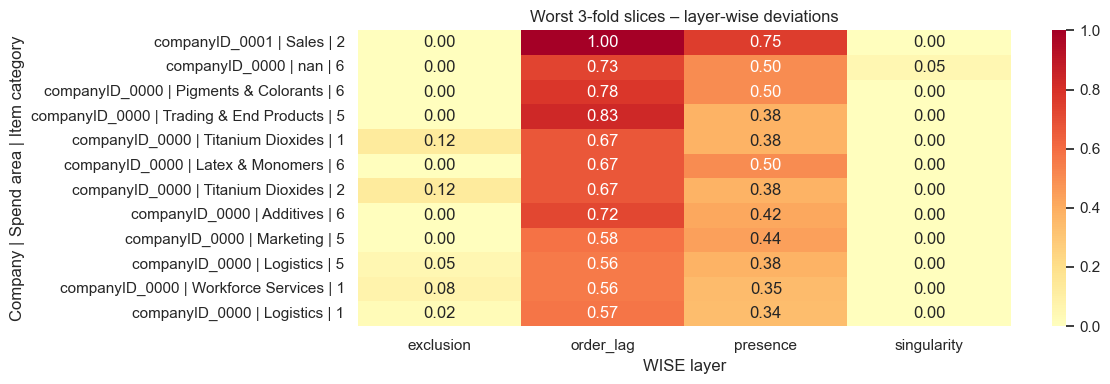

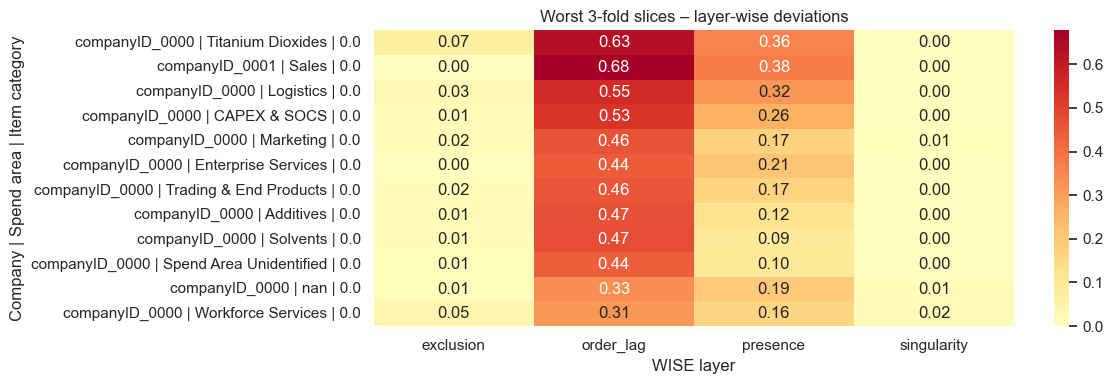

In [14]:

def show_threefold_slices(first_category: str = "case Company", second_category: str = "case Spend area text", third_category: str = "start_dow"):

    case_full["threefold_slice"] = (
    case_full[first_category].astype(str) + " | " +
    case_full[second_category].astype(str) + " | " +
    case_full[third_category].astype(str)
)


    threefold_means = (
        case_full.groupby("threefold_slice")[violation_cols]
        .mean()
        .reset_index()
    )
    threefold_means["mean_badness"] = threefold_means[violation_cols].mean(axis=1)
    top_threefold = threefold_means.sort_values("mean_badness", ascending=False).head(12)

    heat_three = top_threefold.set_index("threefold_slice")[violation_cols]
    heat_three.columns = [c.replace("violation_", "") for c in heat_three.columns]

    plt.figure(figsize=(12,4))
    sns.heatmap(heat_three, cmap="RdYlGn_r", center=0, annot=True, fmt=".2f")
    plt.xlabel("WISE layer")
    plt.ylabel("Company | Spend area | Item category")
    plt.title("Worst 3-fold slices – layer-wise deviations")
    plt.tight_layout()
    plt.show()

show_threefold_slices()
show_threefold_slices(third_category="auto_ratio")

These heatmaps highlight, for example:

- that all problematic slices are **within the same company** (common in BPIC’19),
- that Logistics, CAPEX & SOCS and some Marketing/Services categories are the
  main drivers of Finance-view badness.

---

## 5. Cluster visualisations

The feature table includes `cluster` (0–3). To understand what these clusters
represent, we can look at average features and scores per cluster.

In [15]:
cluster_summary = features.groupby("cluster")[[
    "po_to_gr_days", "gr_to_inv_days", "inv_to_clear_days",
    "n_events", "n_gr", "n_inv", "n_clear", "n_price_changes",
    "n_users", "auto_ratio",
    "n_multi_activities", "sum_multi_events",
    "n_multi_change_activities", "sum_multi_change_events",
]].mean().round(2)
cluster_summary

,po_to_gr_days,gr_to_inv_days,inv_to_clear_days,n_events,n_gr,n_inv,n_clear,n_price_changes,n_users,auto_ratio,n_multi_activities,sum_multi_events,n_multi_change_activities,sum_multi_change_events
cluster,,,,,,,,,,,,,,
0,14.01,38.17,33.48,7.96,1.68,1.21,1.05,0.09,5.20,0.0,0.55,2.54,0.01,0.03
1,3.69,20.14,15.74,15.44,3.14,0.21,0.07,0.02,2.32,0.0,1.06,13.07,0.00,0.01
2,27.78,14.78,22.33,137.20,30.94,29.82,14.41,1.49,11.68,0.0,7.42,134.58,0.45,1.18
3,0.02,36.11,35.86,198.91,53.77,0.62,0.38,0.00,2.87,0.0,2.16,196.85,0.00,0.00


Add WISE scores per cluster (join with `scores`):

In [16]:
df_cluster = features.merge(scores[["case concept:name", "score"]],
                            on="case concept:name", how="left")
df_cluster.groupby("cluster")["score"].describe()

,count,mean,std,min,25%,50%,75%,max
cluster,,,,,,,,
0,9837.0,0.892371,0.074284,0.475,0.870833,0.925,0.925000,1.0
1,4418.0,0.668957,0.095122,0.400,0.650000,0.650,0.650000,1.0
2,190.0,0.858162,0.095568,0.625,0.800000,0.850,0.925000,1.0
3,737.0,0.727391,0.112189,0.575,0.650000,0.650,0.845833,1.0


To visualise:

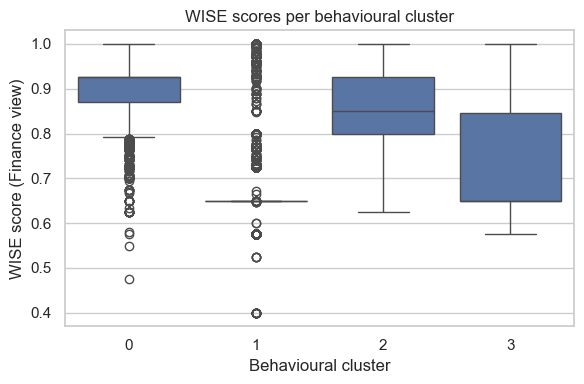

In [17]:
plt.figure(figsize=(6,4))
sns.boxplot(data=df_cluster, x="cluster", y="score")
plt.xlabel("Behavioural cluster")
plt.ylabel("WISE score (Finance view)")
plt.title("WISE scores per behavioural cluster")
plt.tight_layout()
plt.show()

**Interpretation.**

- Clusters with low median scores are **behaviourally problematic**.
- If those clusters also have high `n_price_changes`, `n_multi_events`,
  and low `auto_ratio`, they correspond to “messy manual cases”.
- High-scoring clusters may be **good candidates for further automation**,
  because behaviour is already stable.

You can also create a heatmap of cluster vs automation level (`auto_level` in
`slice_summary`):

/opt/miniconda3/envs/wise-env/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))
/opt/miniconda3/envs/wise-env/lib/python3.10/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


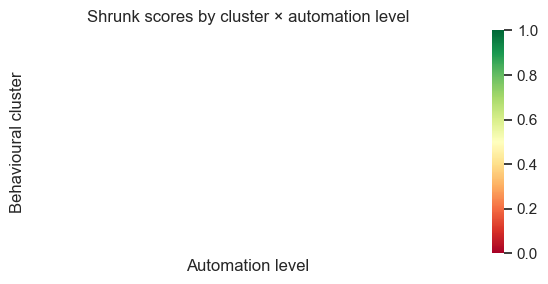

In [18]:
pivot_cluster_auto = slice_summary.pivot_table(
    index="cluster",
    columns="auto_level",
    values="shrunk_score",
)

plt.figure(figsize=(6,3))
sns.heatmap(pivot_cluster_auto, cmap="RdYlGn", vmin=0, vmax=1,
            annot=True, fmt=".2f")
plt.xlabel("Automation level")
plt.ylabel("Behavioural cluster")
plt.title("Shrunk scores by cluster × automation level")
plt.tight_layout()
plt.show()

This tells you, for example:

- Cluster 1 at **low automation** has poor scores → potential candidate for
  standardisation and automation.
- Some clusters remain good even at lower automation → more robust processes.

---

## 6. SHAP: explaining WISE badness from features

### 6.1. Build the ML dataset

We now build a dataset `df_ml` that combines features and WISE scores.

In [19]:
CASE_COL = "case concept:name"

df_ml = features.merge(scores[[CASE_COL, "score"]], on=CASE_COL, how="left")
df_ml["badness"] = 1.0 - df_ml["score"]  # [0,1], higher = worse
df_ml = df_ml.dropna(subset=["badness"])

Feature columns:

In [20]:
feature_cols = [
    "n_clear", "n_inv", "inv_to_clear_days", "gr_to_inv_days",
    "n_gr", "n_users",
    "po_to_gr_days",
    "sum_multi_events", "n_multi_activities",
    "n_events", "n_manual_events",
    "sum_multi_change_events", "n_multi_change_activities",
    "start_month", "start_dow",
]
X = df_ml[feature_cols].fillna(0.0).values.astype("float64")
y = df_ml["badness"].values

### 6.2. Train model and interpret R²

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import shap
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

rf = RandomForestRegressor(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    n_jobs=-1,
)
rf.fit(X_train, y_train)
r2 = rf.score(X_test, y_test)
r2

0.9880349252448893

You observed:

> **R² on holdout: 0.9879**

This means the model explains **~98.8% of the variance** in WISE badness on
the holdout set. That is extremely high, but it is plausible because:

- WISE badness is itself a **deterministic function** of violations derived
  from event counts and durations,
- the features (`n_clear`, `n_inv`, `inv_to_clear_days` etc.) are very close
  to the inputs used to compute WISE violations.

In other words, the model is practically rediscovering the WISE scoring
function, which is expected and confirms that the selected features strongly
encode “what WISE cares about”.

### 6.3. Global SHAP summary

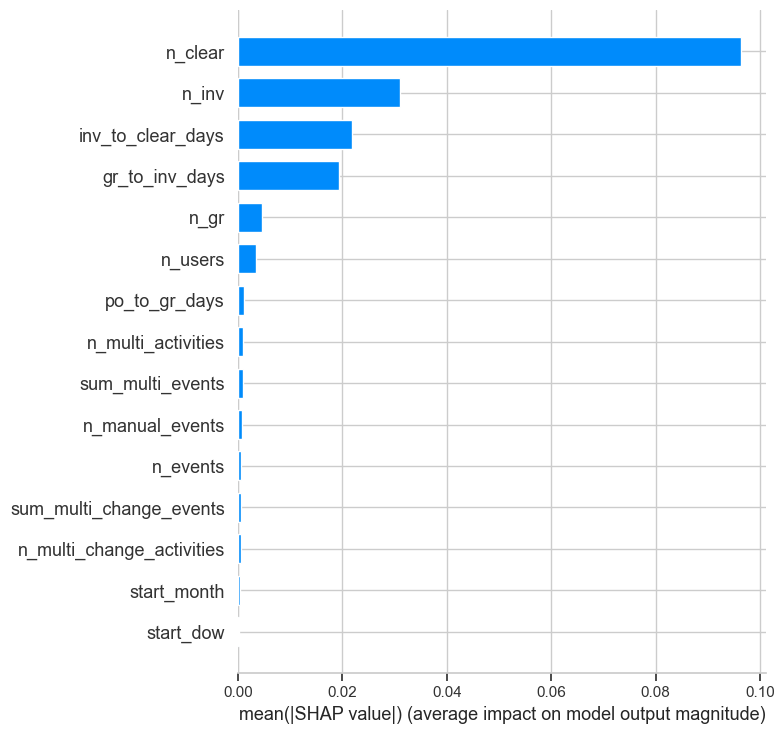

In [22]:
explainer = shap.TreeExplainer(rf)
X_test_enc = X_test.astype(np.float64)
shap_values = explainer.shap_values(X_test_enc)

shap.summary_plot(
    shap_values,
    X_test_enc,
    feature_names=feature_cols,
    plot_type="bar",
)

In your plot `n_clear` and `n_inv` dominate, followed by
`inv_to_clear_days` and `gr_to_inv_days`.

**Interpretation.**

- **`n_clear`** – number of CLEAR events per case  
  - High SHAP impact: whether an invoice is cleared (and how many times) is
    central to Finance-view WISE badness. Missing CLEAR (0) or multiple CLEARs
    indicate compliance/timing issues.
- **`n_inv`** – number of INVOICE events per case  
  - Cases with no invoice or multiple invoices are critical.
- **`inv_to_clear_days`** – lead time from INV to CLEAR  
  - Long delays raise badness due to blocked invoice days and missed targets.
- **`gr_to_inv_days`** – lead time from GR to INV  
  - Deviations from expectations (e.g. invoice much earlier or much later than
    GR) contribute significantly to badness.
- `n_gr`, `n_users`, etc. also matter, but to lesser extent globally.

This lines up perfectly with Finance’s concerns:

> Are invoices complete, timely, and cleared quickly? Is the number of GR and
> INV events per PO line reasonable, or do we have unusual fragmentation or
> duplication?

### 6.4. SHAP local explanation – specific bad case

You showed a **force plot** similar to:

- base value around 0.2,
- final prediction ~0.60,
- major contributors: `n_users=4`, `n_gr=0`, `n_inv=0`, `n_clear=0`.

This case has:

- no GR, no INV, no CLEAR,
- several users involved.

SHAP indicates that **absence of required events** and **multiple users**
drive badness. For a 3-way after GR, this likely violates L1 (presence) and
L2 (order/lag).

In human terms:

> *“This PO line involved several people but never produced GR, INV or CLEAR
> events. It is either incomplete, incorrectly recorded, or handled entirely
> outside the standard P2P process. It deserves attention as potential
> process/control gap.”*

---

## 7. LIME explanations

For a numeric example (from your screenshot), LIME might produce rules like:

- `0 < n_clear <= 1` → decreases badness (good to have exactly one CLEAR),
- `0 < n_inv <= 1` → decreases badness (exactly one invoice),
- `inv_to_clear_days > 30` → increases badness,
- `n_manual_events` between 5 and 10 → slightly increases badness,
- `n_users > 5` → minor increase in badness.

These align with the idea that:

- correct presence of exactly one INV and CLEAR reduces badness,
- long INV→CLEAR durations raise badness,
- many manual events and users are proxies for rework/complexity.

---

## 8. From insights to concrete improvements

Combining heatmaps, slice rankings, clusters, and SHAP/LIME, you can craft a
concise improvement story for BPIC’19 P2P.

### 8.1. Logistics 3-way after GR (Finance view)

Evidence:

- Heatmaps and bar charts show `companyID_0000 | Logistics | 3-way after GR`
  as lowest scoring and highest PI slice.
- Layer-wise heatmap: high L3 and L4 deviations.
- SHAP: `n_clear`, `n_inv`, `inv_to_clear_days`, `gr_to_inv_days` are top
  drivers of badness.
- Case-level SHAP/LIME: bad cases in this slice often have no or multiple
  GR/INV/CLEAR events, long delays, many manual events and users.

Interpretation:

- GR and INV handling in Logistics is **fragmented and late**.
- Price changes and rework around GR/INV cause frequent mismatches.
- Approvals and clearing steps are slow or inconsistent.

Improvement ideas:

1. **Standardise GR and INV posting**
   - Use policy: “one GR per delivery, one INV per GR” with clear tolerances.
   - Enforce timely GR posting; disallow retroactive GR beyond a small window.
   - Monitor `n_gr`, `n_inv`, `gr_to_inv_days` and L3/L4 violations via WISE
     dashboards.

2. **Tighten price-change controls**
   - Restrict price changes after GR; require justification and higher-level
     approval.
   - Link late price changes to blocked invoices and measure their impact
     on `inv_to_clear_days`.

3. **Streamline invoice approval chain**
   - Analyse `n_users` and `n_manual_events` per case in this slice.
   - Simplify approvers, introduce thresholds for auto-approval on low-risk
     invoices.

### 8.2. CAPEX & SOCS 3-way after GR

Evidence:

- Moderately low WISE scores, strong L2 and L3 deviations.
- SHAP emphasises `inv_to_clear_days` and `gr_to_inv_days`.

Interpretation:

- CAPEX invoices are often cleared very late, perhaps due to multi-level
  approvals or late GR posting after project milestones.

Improvements:

- Set target INV→CLEAR SLAs for CAPEX & SOCS.
- Align project milestone confirmations (GR) with invoice schedules.
- Introduce automated reminders and escalate overdue approvals.

### 8.3. Other spend areas (Services, Marketing, Enterprise)

Evidence:

- Mixed scores; some slices show L2 issues, others L3/L4.
- Clusters with low automation ratio and high multiplicity correlate with
  worse WISE scores.

Improvements:

- For service spend areas:
  - Clarify service acceptance criteria to avoid late GR events.
  - Standardise PO lines (e.g. fewer free-text items) to reduce rework.
- For Marketing/Enterprise slices with good scores but manual processing:
  - Explore automation (e-invoices, auto-match) in these stable segments.

---

## 9. Structured improvement backlog

You can turn these insights into a simple backlog table:

In [23]:
%%markdown
| Priority | Slice (view)                                           | Dominant layers | Key drivers                  | Proposed actions                              |
|---------:|--------------------------------------------------------|-----------------|------------------------------|-----------------------------------------------|
| 1        | companyID_0000 · Logistics · 3-way after GR (Finance)  | L3, L4, L1      | n_clear, n_inv, inv_to_clear | Standardise GR/INV, tighten price changes     |
| 2        | companyID_0000 · CAPEX & SOCS · 3-way after GR         | L2, L3          | inv_to_clear_days            | SLA on INV→CLEAR, streamline CAPEX approvals  |
| 3        | companyID_0000 · Trading & End Products · 3-way after GR | L3, L4        | n_gr, n_price_changes        | Review contract templates, reduce fragmentation |
| 4        | High-complexity, low automation cluster                | mixed           | n_manual_events, n_users     | Automation roadmap, training                  |

| Priority | Slice (view)                                           | Dominant layers | Key drivers                  | Proposed actions                              |
|---------:|--------------------------------------------------------|-----------------|------------------------------|-----------------------------------------------|
| 1        | companyID_0000 · Logistics · 3-way after GR (Finance)  | L3, L4, L1      | n_clear, n_inv, inv_to_clear | Standardise GR/INV, tighten price changes     |
| 2        | companyID_0000 · CAPEX & SOCS · 3-way after GR         | L2, L3          | inv_to_clear_days            | SLA on INV→CLEAR, streamline CAPEX approvals  |
| 3        | companyID_0000 · Trading & End Products · 3-way after GR | L3, L4        | n_gr, n_price_changes        | Review contract templates, reduce fragmentation |
| 4        | High-complexity, low automation cluster                | mixed           | n_manual_events, n_users     | Automation roadmap, training                  |


Each row is linked to:

- visual evidence (heatmaps, bar charts, SHAP/LIME),
- a WISE norm (L1–L5 expectations),
- and clear follow-up actions.

---

## 10. Summary

This notebook demonstrates how to:

1. **Translate WISE scores into slice-first priorities** using shrunk scores,
   gaps, and a Priority Index.
2. **Interpret layer-wise deviations** through heatmaps over slices, revealing
   whether problems are missing steps, timing, mismatches, rework or forbidden
   patterns.
3. **Use behavioural clusters and automation levels** to understand which sets
   of cases are inherently messy vs ripe for automation.
4. **Employ SHAP and LIME** on top of engineered features to explain WISE
   badness at both **global** and **local** levels:
   - globally, counts of INV/CLEAR and lead times explain almost all variance
     (R² ≈ 0.988),
   - locally, absence of required events, long delays and high manual effort
     are key drivers in bad cases.
5. **Derive concrete P2P improvement initiatives** tailored to BPIC’19’s
   non-product-related spend context, focusing on Logistics, CAPEX & SOCS,
   and service-related spend areas.

Running this notebook regularly with updated data allows Finance and
Procurement to monitor whether those improvements are actually closing the
gaps identified by WISE and pushing the low-scoring slices up towards the
norm.
